Установите QP-солвер, разберитесь с его интерфейсом.
Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
Какие из ограничений-неравенств задачи являются активными, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [2]:
#Задание №1: Установка QP-солвера
import numpy as np
from cvxopt import matrix
from cvxopt import solvers
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

Для решения поставленной задачи необходимо задать матрицы P, q, G, h. Также необходимо учитывать формулу квадратичного программирования для обучения модели:

In [2]:
P = matrix(np.diag([2., 8.]))
q = matrix(np.array([-8., -16.]))
G = matrix(np.array([[1., 1.], [1., 0.], [-1., 0.], [0., -1.]]))
h = matrix(np.array([5., 3., 0., 0.]))

sol = solvers.qp(P, q, G, h)
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -3.0512e+01 -3.8829e+01  8e+00  0e+00  2e-01
 1: -3.0792e+01 -3.1146e+01  4e-01  2e-16  5e-03
 2: -3.0982e+01 -3.1024e+01  4e-02  2e-16  4e-04
 3: -3.0997e+01 -3.1003e+01  6e-03  9e-17  4e-17
 4: -3.1000e+01 -3.1000e+01  7e-04  2e-16  5e-18
 5: -3.1000e+01 -3.1000e+01  1e-04  2e-16  3e-17
 6: -3.1000e+01 -3.1000e+01  1e-05  2e-16  3e-17
Optimal solution found.
[ 3.00e+00]
[ 2.00e+00]



Исключим условие x1+x2<=
5

In [ ]:
P = matrix(np.diag([2., 8.]))
q = matrix(np.array([-8., -16.]))
G = matrix(np.array([[1., 0.], [-1., 0.], [0., -1.]]))
h = matrix(np.array([3., 0., 0.]))

sol = solvers.qp(P, q, G, h)
print(sol['x'])

Исключим условие x1<=3

In [ ]:
P = matrix(np.diag([2., 8.]))
q = matrix(np.array([-8., -16.]))
G = matrix(np.array([[1., 1.], [-1., 0.], [0., -1.]]))
h = matrix(np.array([5., 0., 0.]))

sol = solvers.qp(P, q, G, h)
print(sol['x'])

Исключим условие x1>=0

In [ ]:
P = matrix(np.diag([2., 8.]))
q = matrix(np.array([-8., -16.]))
G = matrix(np.array([[1., 1.], [1., 0.], [0., -1.]]),  tc='d')
h = matrix(np.array([5., 3., 0.]),  tc='d')

sol = solvers.qp(P, q, G, h)
print(sol['x'])

Исключим условие x2>=0

In [ ]:
P = matrix(np.diag([2., 8.]))
q = matrix(np.array([-8., -16.]))
G = matrix(np.array([[1., 1.], [1., 0.], [-1., 0.]]))
h = matrix(np.array([5., 3., 0.]))

sol = solvers.qp(P, q, G, h)
print(sol['x'])

**Ответ**: активное условие х1>=3, все остальные можно выкинуть

# **2.Линейный SVM**

In [13]:
from sklearn.datasets import make_classification, make_gaussian_quantiles, make_circles
from matplotlib import pyplot as plt

In [4]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C=1, transform=None):
        self.C = C
        self.transform = transform

    def fit(self, X, y):
        if self.transform:
            #присоединяем данные по горизонтальной оси
            X = self.transform(X.copy())
        N, d = X.shape
        P = np.zeros((N + 1 + d, N + 1 + d))
        P[:d,:d] = np.eye(d)
        q = np.hstack(([0.]*(d + 1), [self.C]*N))
        G1 = np.hstack((-y.reshape(N, 1)*X, -y.reshape(N, 1), -np.eye(N)))
        G2 = np.hstack((np.zeros((N, d + 1)), -np.eye(N)))
        #присоединяем данные по вертикальной оси
        G = np.vstack((G1, G2))
        h = np.hstack(([-1.]*N, [0.]*N))

        solvers.options['show_progress'] = False
        sol = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h))
        self.w = np.array(sol['x'][:d]).flatten()
        self.b = float(np.array(sol['x'][d:d+1]))
        self.ksi = np.array(sol['x'][d+1:]).flatten()

        self.vect = list()
        self.vect_class = list()
        for i in range(N):
            if (np.absolute(y[i] * (self.w.T.dot(X[i]) + self.b) - 1) < 1e-6) or (self.ksi[i] > 1e-6):
                self.vect.append(X[i])
                self.vect_class.append(y[i])
        self.vect = np.array(self.vect); self.vect_class = np.array(self.vect_class)

    def predict_proba(self, X):
        if self.transform:
            X = self.transform(X.copy())
        return (np.dot(X, self.w) + self.b).flatten()

    def predict(self, X):
        if self.transform:
            X = self.transform(X.copy())
        return np.sign(self.predict_proba(X))

In [5]:
def images_svm(X, y, C, i, j, transform=None):
    model = LinearSVM(C, transform)
    model.fit(X, y)

    ax[j][i].scatter(X[:, 0], X[:, 1], s=20, c=y, cmap='spring', edgecolor='green')
    ax[j][i].scatter(model.vect[:, 0], model.vect[:, 1], s=50, marker='o',
                     c=model.vect_class, cmap='winter', edgecolor='green')

  # Задание №3
    x1_min = np.min(X[:, 0]) - 1
    x1_max = np.max(X[:, 0]) + 1
    x2_min = np.min(X[:, 1]) - 1
    x2_max = np.max(X[:, 1]) + 1

    ax[j][i].set_xlim([x1_min, x1_max]) 
    ax[j][i].set_ylim([x2_min, x2_max]) 

    xvals = np.linspace(x1_min, x1_max, 100)
    yvals = np.linspace(x2_min, x2_max, 100)

    xx, yy = np.meshgrid(xvals, yvals)
    zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)

    ax[j][i].pcolormesh(xx, yy, zz, cmap='RdGy_r', zorder=0, shading='auto')
    ax[j][i].contour(xx, yy, zz, colors=["k", "black", "k"],
                     linestyles=["-", "--", "-"], levels=[-1, 0, 1])
    ax[j][i].text(x1_min + 0.5, x2_max - 0.5, ('Количество опорных векторов: '+str(len(model.vect))))

In [16]:
from types import new_class
 #Задание №2
X = [[]]*3; y = [[]]*3

X[0], y[0] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=9087596)
X[1], y[1] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=1000)
X[2], y[2] = make_gaussian_quantiles(n_samples=100, n_features=2, n_classes=2)

X = np.array(X)
y = np.array(y)
titles = ["Линейно-разделимая", "Нелинейно разделимая", "Плохо разделимая"]
C = 10. ** np.arange(-1,1)

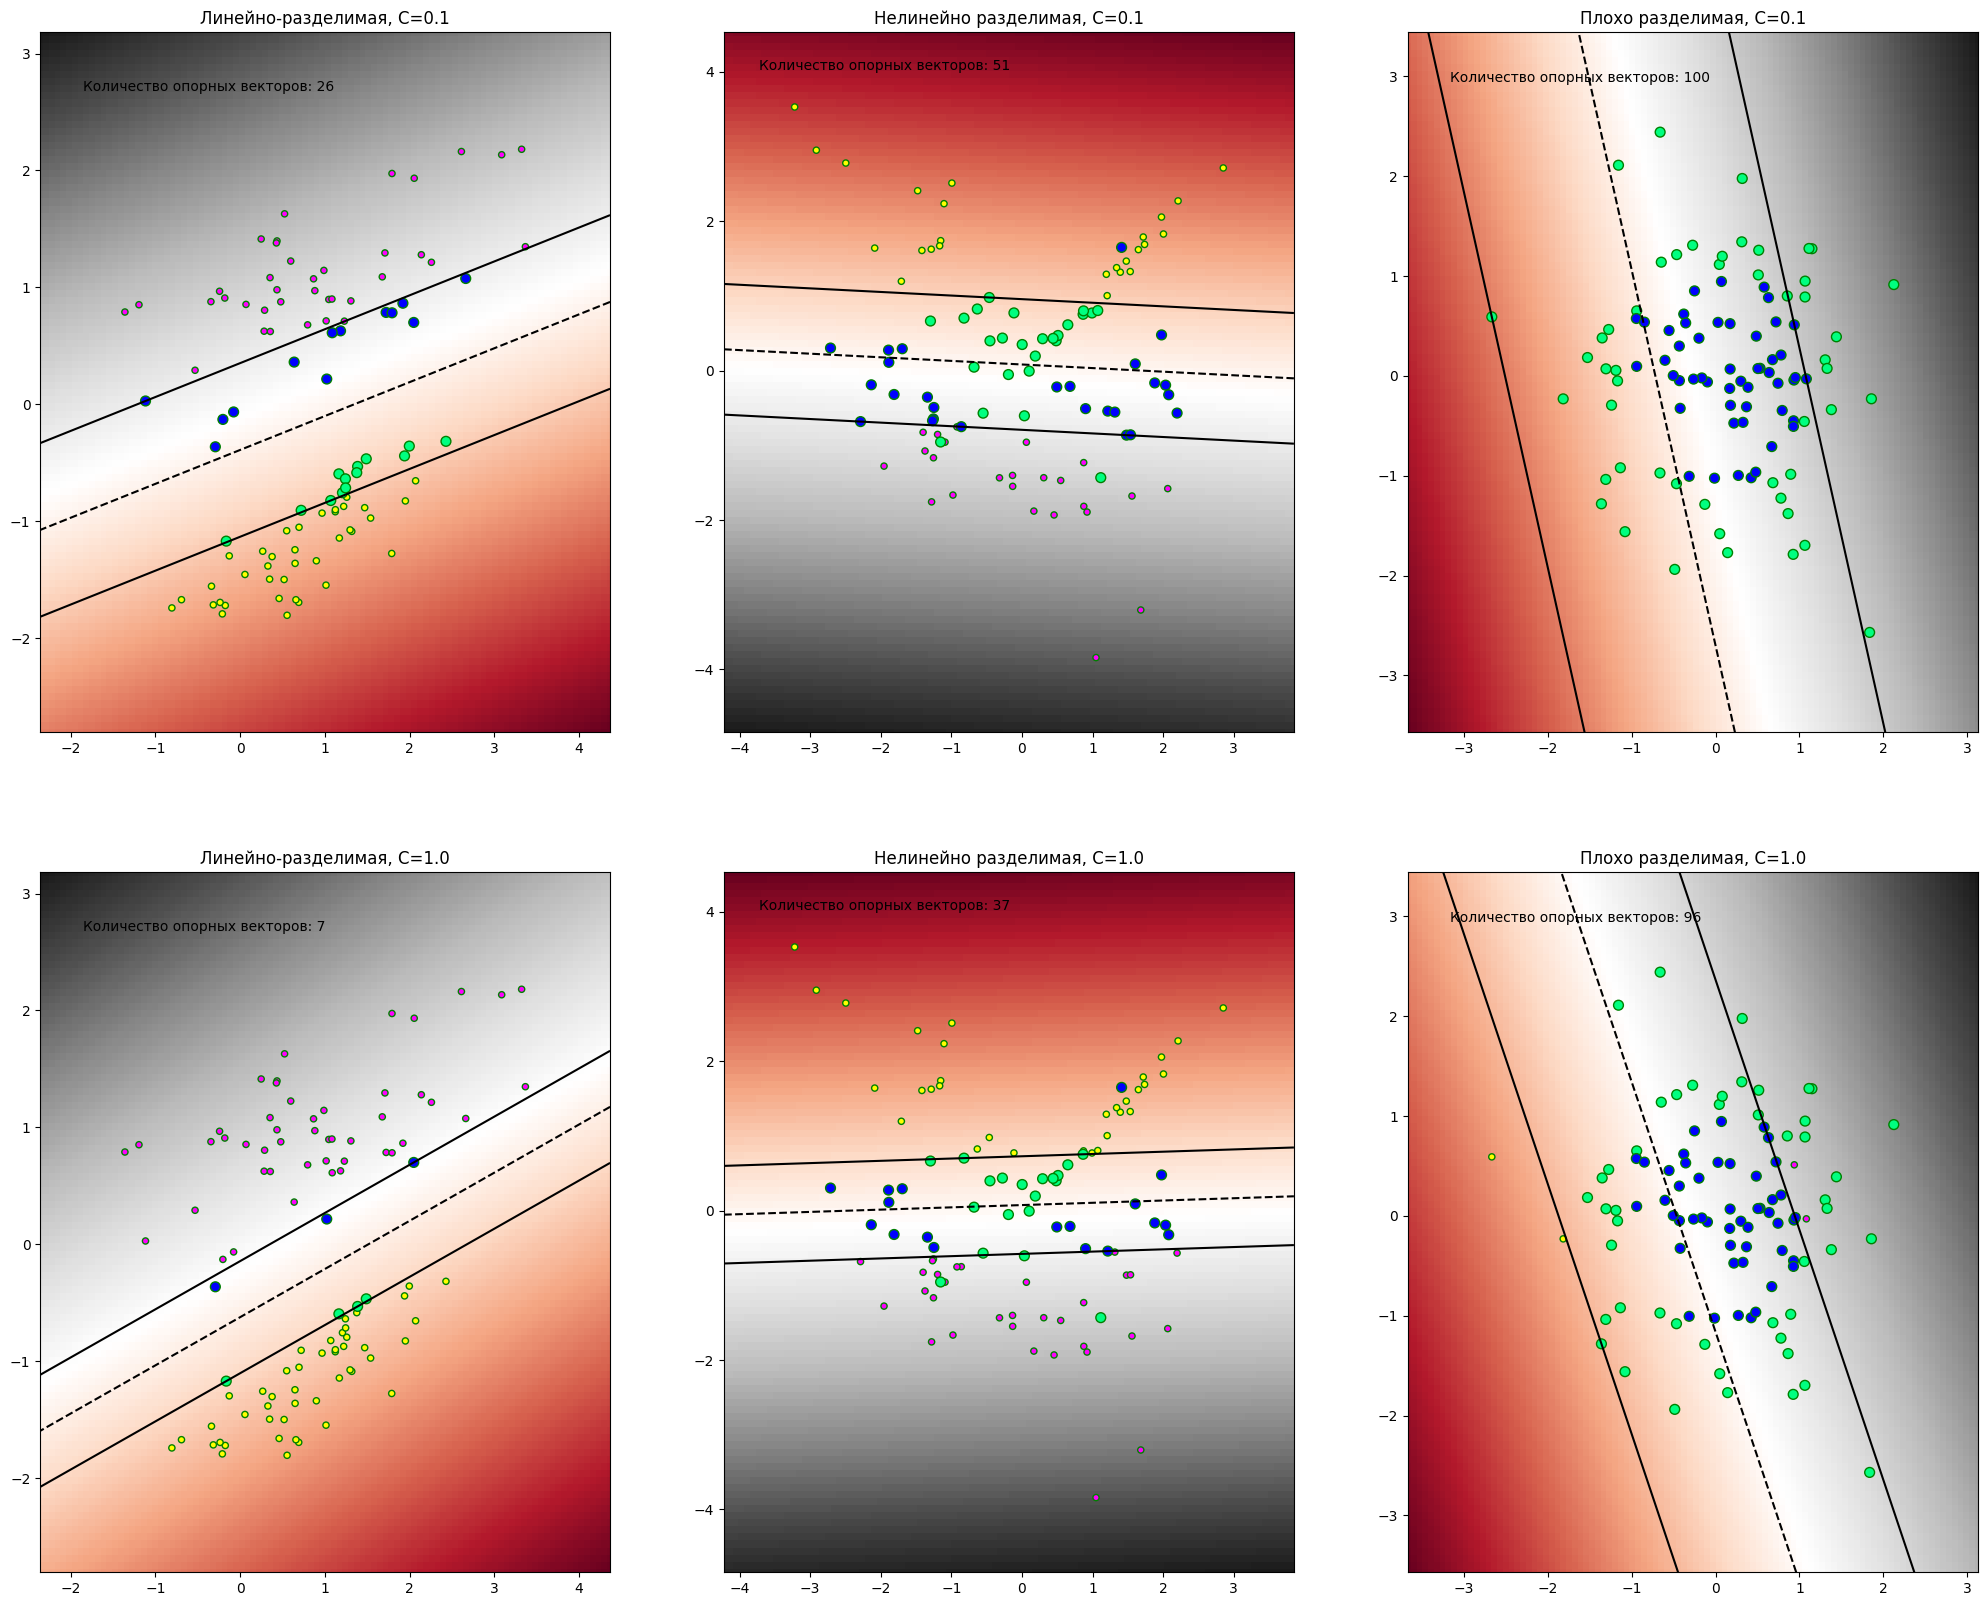

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(25,20))
for i in range(3):
    y[i][y[i] == 0] = -1
    for j in range(2):
        images_svm(X[i], y[i], C[j], i, j)
        ax[j][i].set_title(titles[i]+', C='+str(C[j]))

Увеличивая С мы уменьшаем количество опорных векторов

In [18]:
def transform(X):
    transform_X = list()
    d = X.shape[1]
    for item in X:
        temp = list()
        for i in range(d):
            for j in range(i, d):
                temp.append(item[i] * item[j])
        transform_X.append(np.array(temp))

    return np.hstack((X, np.array(transform_X)))

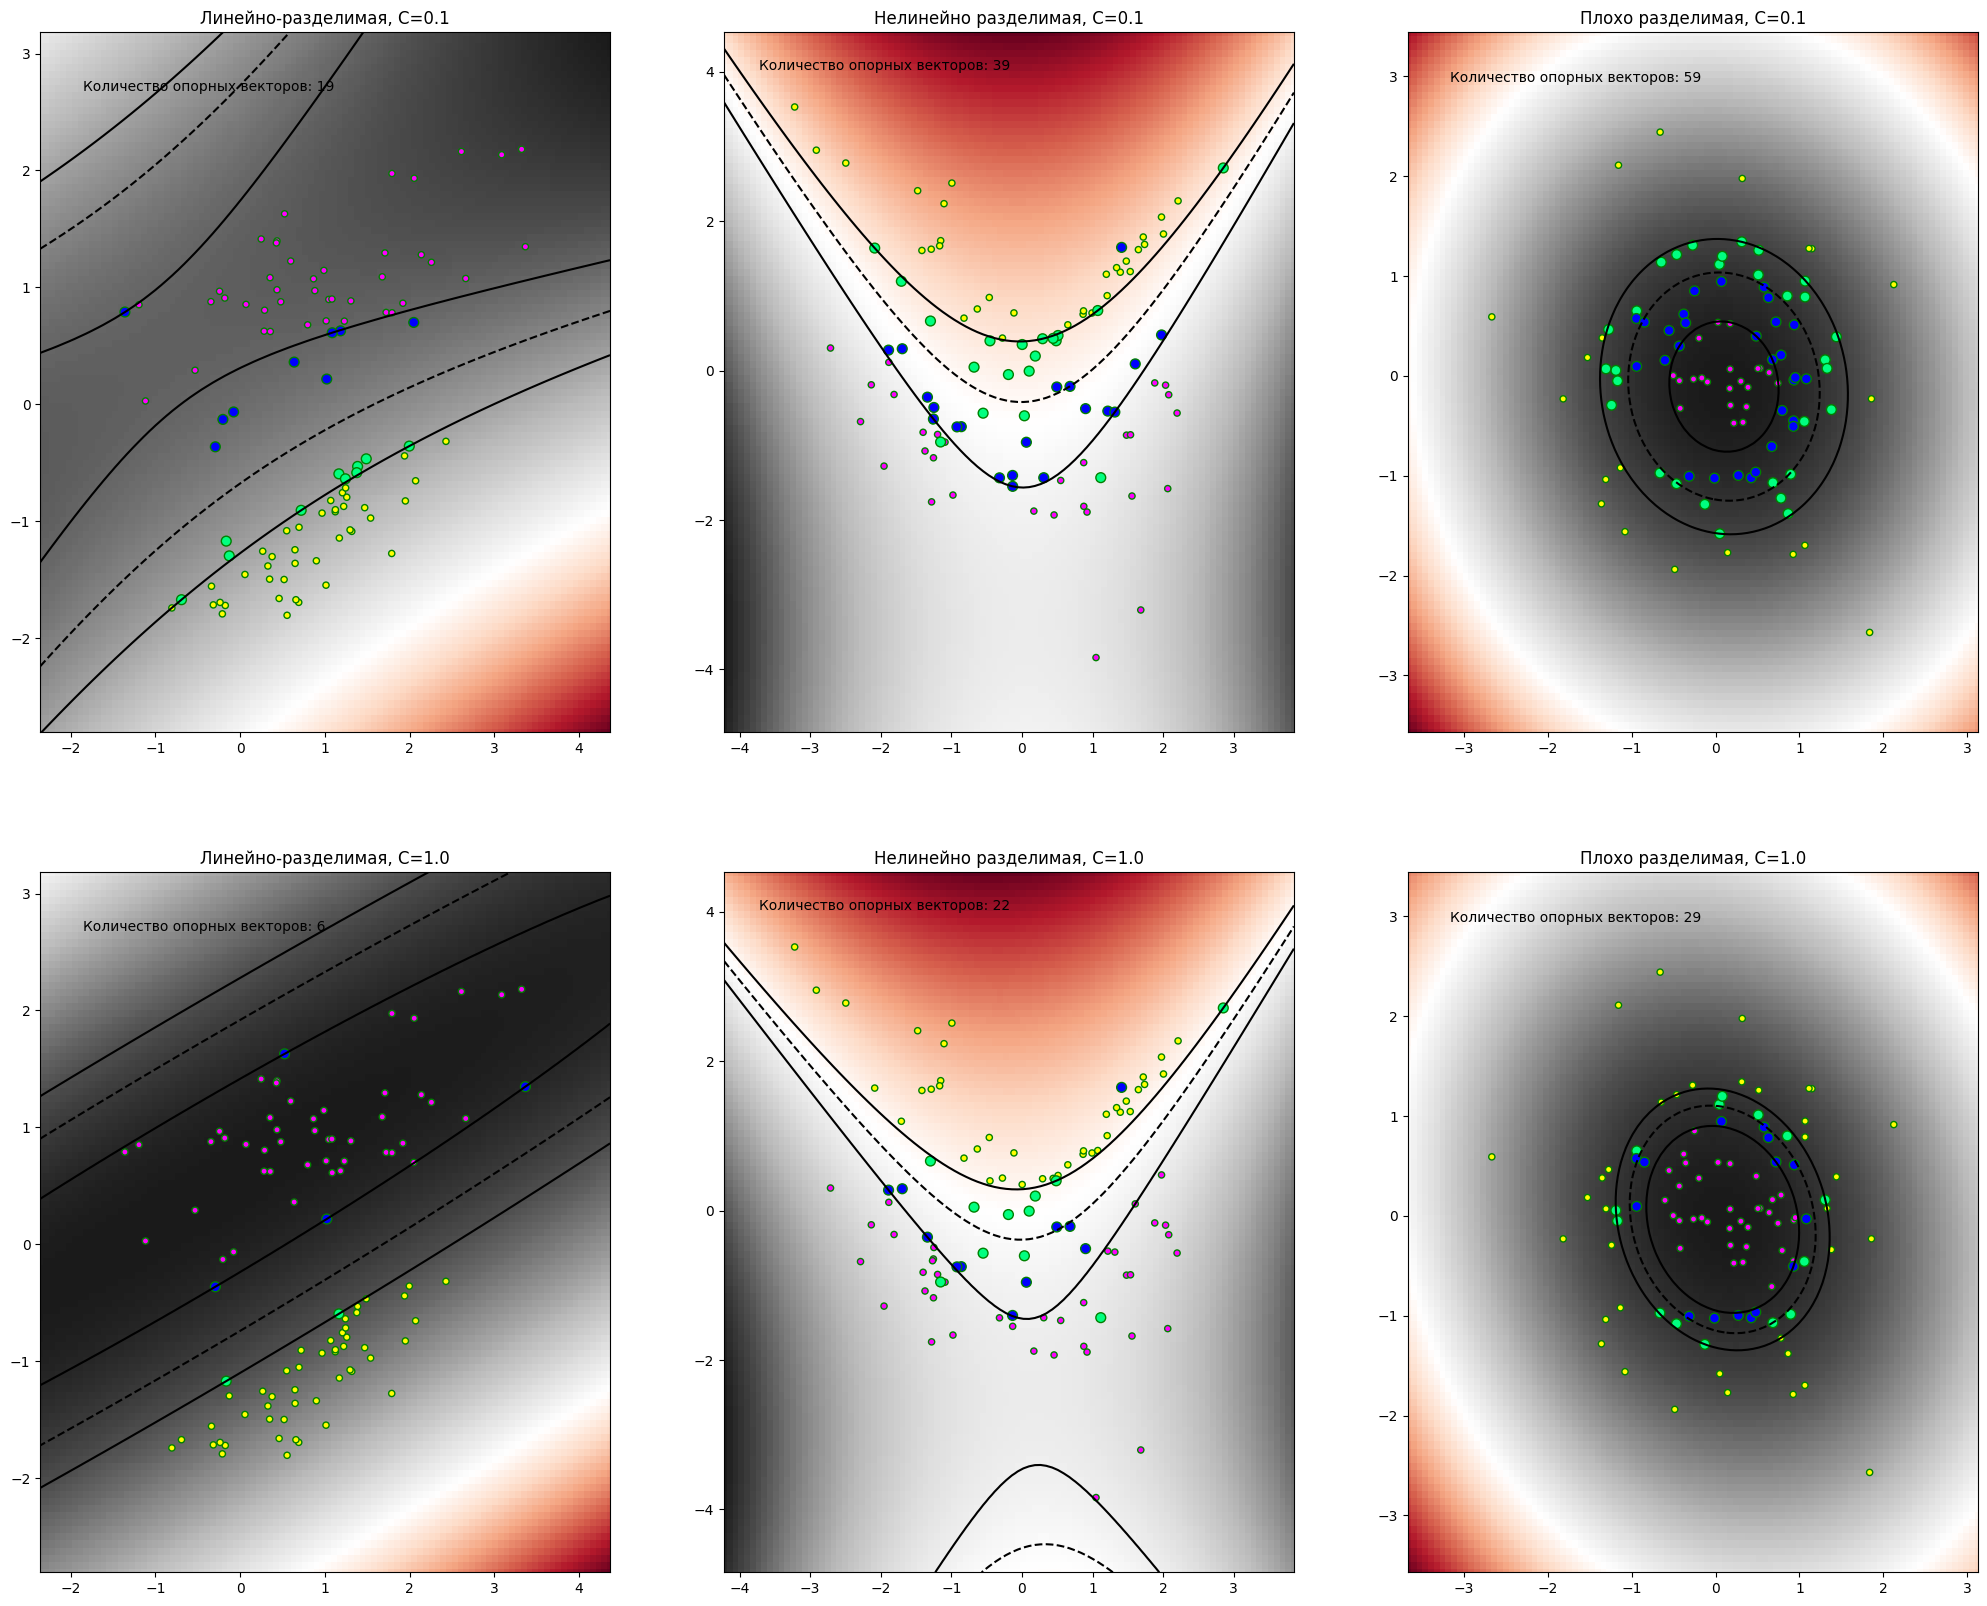

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(25,20))
for i in range(3):
    y[i][y[i] == 0] = -1
    for j in range(2):
        images_svm(X[i], y[i], C[j], i, j, transform=transform)
        ax[j][i].set_title(titles[i]+', C='+str(C[j]))

# 3. Двойственный переход и Ядровой SVM

In [22]:
from sklearn.datasets import make_classification, make_moons, make_circles
from matplotlib import pyplot as plt

In [23]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):

    def __init__(self, C=1, kernel="linear", power=None, gamma=None):
        self.C = C
        self.kernel = kernel
        self.power = power
        self.gamma = gamma

    def _linear(self, x1, x2):
        return np.dot(x1, x2)

    def _poly(self, x1, x2, power):
        return (np.dot(x1, x2) + 1) ** power

    def _RBF(self, x1, x2, gamma):
        distance = np.linalg.norm(x1 - x2) ** 2
        return np.exp(-gamma * distance)

    def fit(self, X, y):
        N, d = X.shape
        K = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                if self.kernel == "linear":
                    K[i, j] = self._linear(X[i], X[j])
                elif self.kernel == "poly":
                    K[i, j] = self._poly(X[i], X[j], self.power)
                else:
                    K[i, j] = self._RBF(X[i], X[j], self.gamma)

        P = matrix(np.outer(y, y) * K, tc='d')
        q = matrix(-np.ones(N), tc='d')
        G = matrix(np.vstack((np.eye(N), -np.eye(N))), tc='d')
        h = matrix(np.hstack((self.C * np.ones(N), np.zeros(N))), tc='d')
        A = matrix(y.reshape(1, N), tc='d')
        b = matrix(0, tc='d')
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        self.alpha = np.array(sol['x']).flatten()

        ind = self.alpha > 1e-6
        self.sup_alpha = self.alpha[ind]
        self.sup_vect = X[ind]
        self.sup_vect_class = y[ind]

        self.b = list()
        for i in range(len(self.sup_vect)):
            temp = 0
            for j in range(len(self.sup_vect)):
                if self.kernel == "linear":
                    temp += self._linear(self.sup_vect[i], self.sup_vect[j])
                elif self.kernel == "poly":
                    temp += self._poly(self.sup_vect[i], self.sup_vect[j], self.power)
                else:
                    temp += self._RBF(self.sup_vect[i], self.sup_vect[j], self.gamma)
            self.b.append(self.sup_vect_class[i] - self.sup_alpha[i]*self.sup_vect_class[i]*temp)
        self.b = np.array(self.b).mean()

    def predict_proba(self, X):
        y_pred = []
        for item in X:
            prediction = 0
            for i in range(len(self.sup_alpha)):
                if self.kernel == "linear":
                    prediction += self.sup_alpha[i] * self.sup_vect_class[i] * self._linear(self.sup_vect[i], item)
                elif self.kernel == "poly":
                    prediction += self.sup_alpha[i] * self.sup_vect_class[i] * self._poly(self.sup_vect[i], item, self.power)
                else:
                    prediction += self.sup_alpha[i] * self.sup_vect_class[i] * self._RBF(self.sup_vect[i], item, self.gamma)
            prediction += self.b
            y_pred.append(prediction)
        return np.array(y_pred)

    def predict(self, X):
        return np.sign(self.predict_proba(X))

def visualize_DualSVM(X, y, i, j, C=1, kernel='linear', power=None, gamma=None):

    model = DualSVM(C = C, kernel = kernel, power = power, gamma = gamma)
    model.fit(X, y)

    ax[j][i].scatter(X[:, 0], X[:, 1], s=20, c=y, cmap='spring', edgecolor='red')
    ax[j][i].scatter(model.sup_vect[:, 0], model.sup_vect[:, 1], s=50, marker='o',
                     c=model.sup_vect_class, cmap='spring', edgecolor='red')

    x1_min = np.min(X[:, 0]) - 1
    x1_max = np.max(X[:, 0]) + 1
    x2_min = np.min(X[:, 1]) - 1
    x2_max = np.max(X[:, 1]) + 1

    ax[j][i].set_xlim([x1_min, x1_max])
    ax[j][i].set_ylim([x2_min, x2_max])

    xvals = np.linspace(x1_min, x1_max, 100)
    yvals = np.linspace(x2_min, x2_max, 100)

    xx, yy = np.meshgrid(xvals, yvals)
    zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)

    ax[j][i].pcolormesh(xx, yy, zz, cmap='RdGy_r', zorder=0, shading='auto')
    ax[j][i].contour(xx, yy, zz, colors=["r", "b", "r"], linestyles=["-", "--", ":"], levels=[-1, 0, 1])

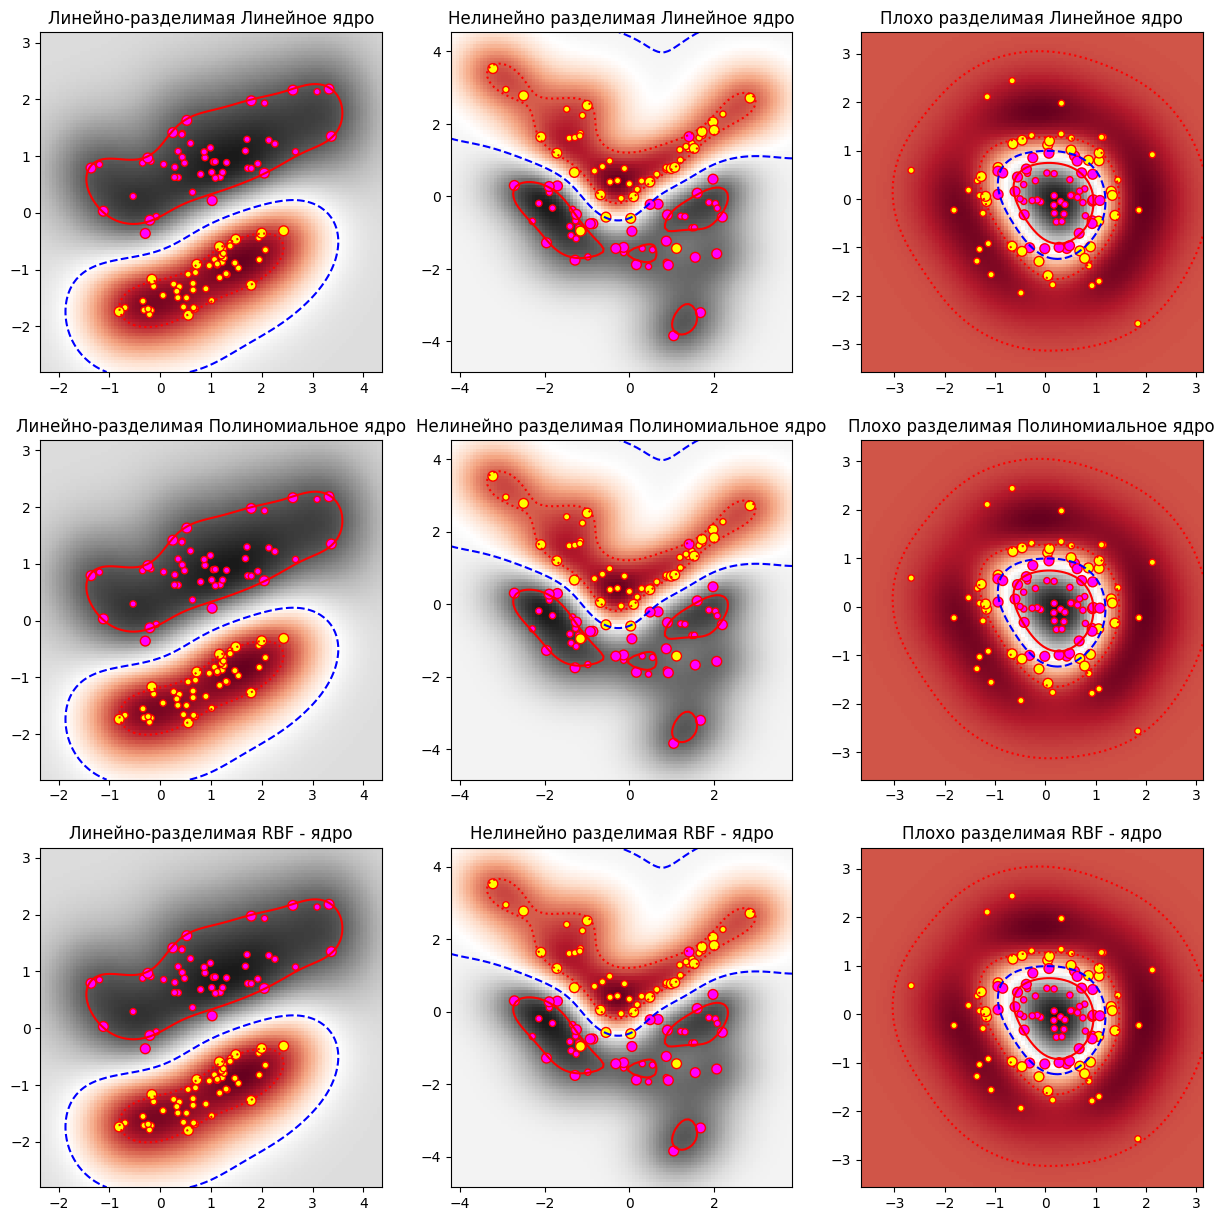

In [24]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))
kernels = ['Линейное', 'Полиномиальное', 'RBF -']
for i in range(3):
    for j in range(3):
        visualize_DualSVM(X[i], y[i], i, j, kernel = kernels[j], power = 2, gamma = 1)
        ax[j][i].set_title(titles[i]+' '+kernels[j]+' ядро')

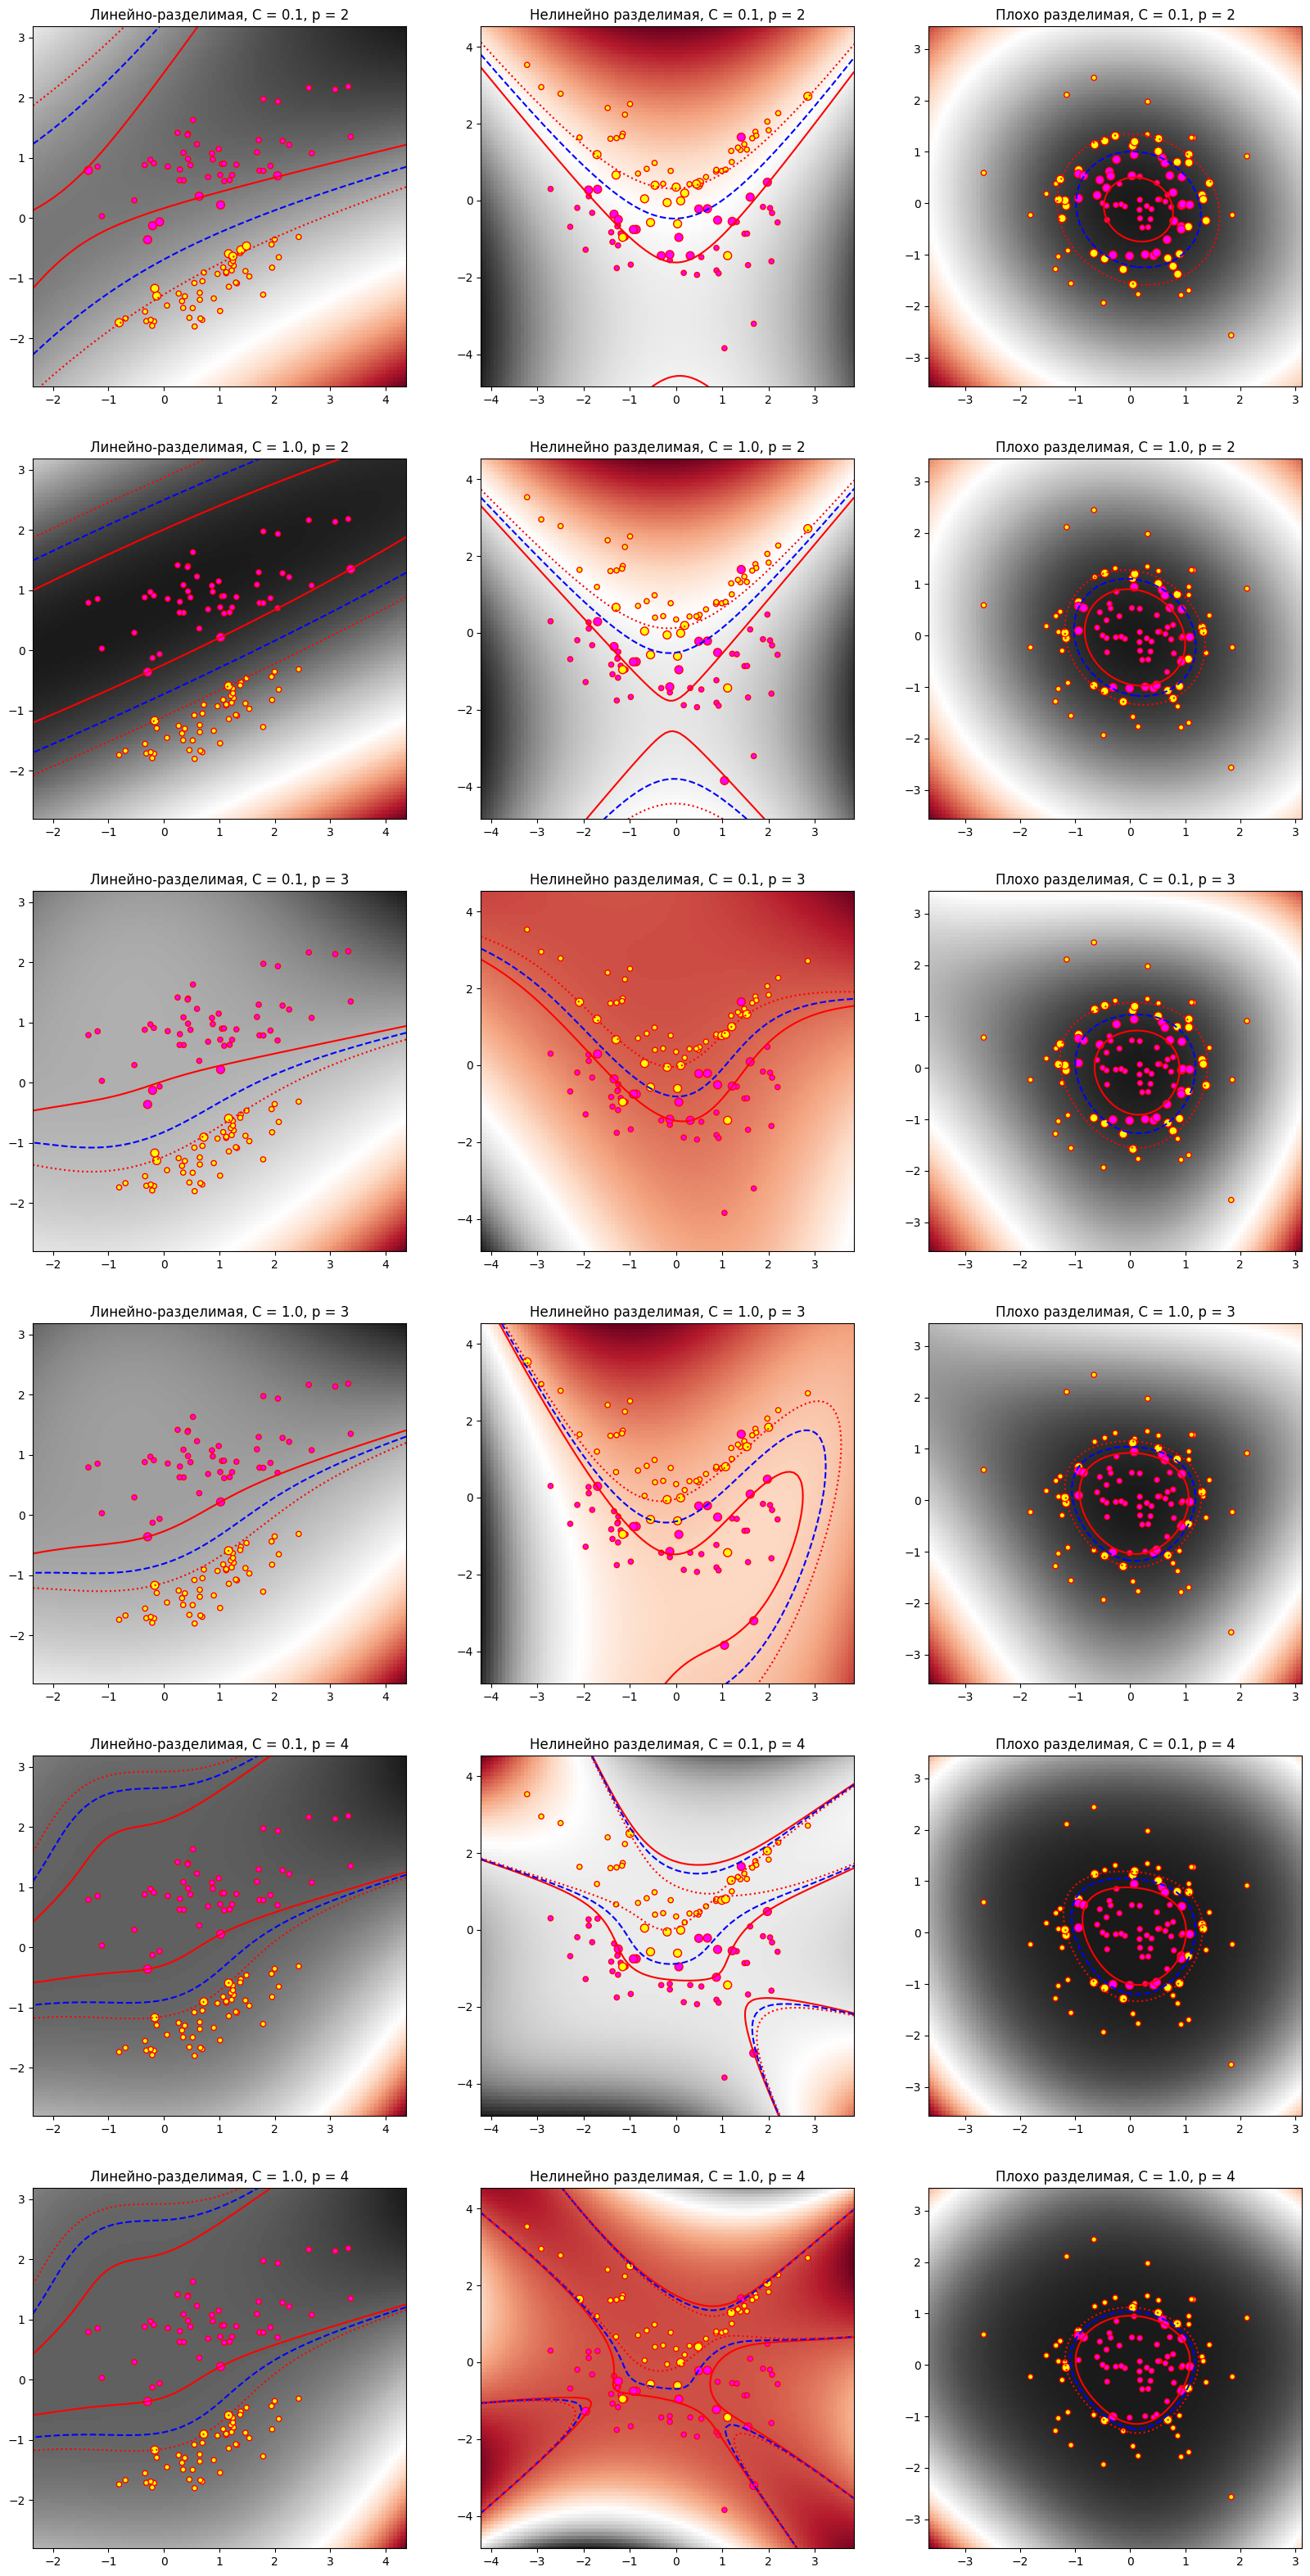

In [26]:
powers = np.arange(2,5)
cvals, pvals = np.meshgrid(C, powers)
pp = pvals.flatten()
cc = cvals.flatten()
fig, ax = plt.subplots(len(pp), 3, figsize=(20,40))
for i in range(3):
    for j in range(len(pp)):
        visualize_DualSVM(X[i], y[i], i, j, cc[j], 'poly', pp[j])
        ax[j][i].set_title(titles[i] + ', C = ' + str(cc[j]) + ', p = ' + str(pp[j]))

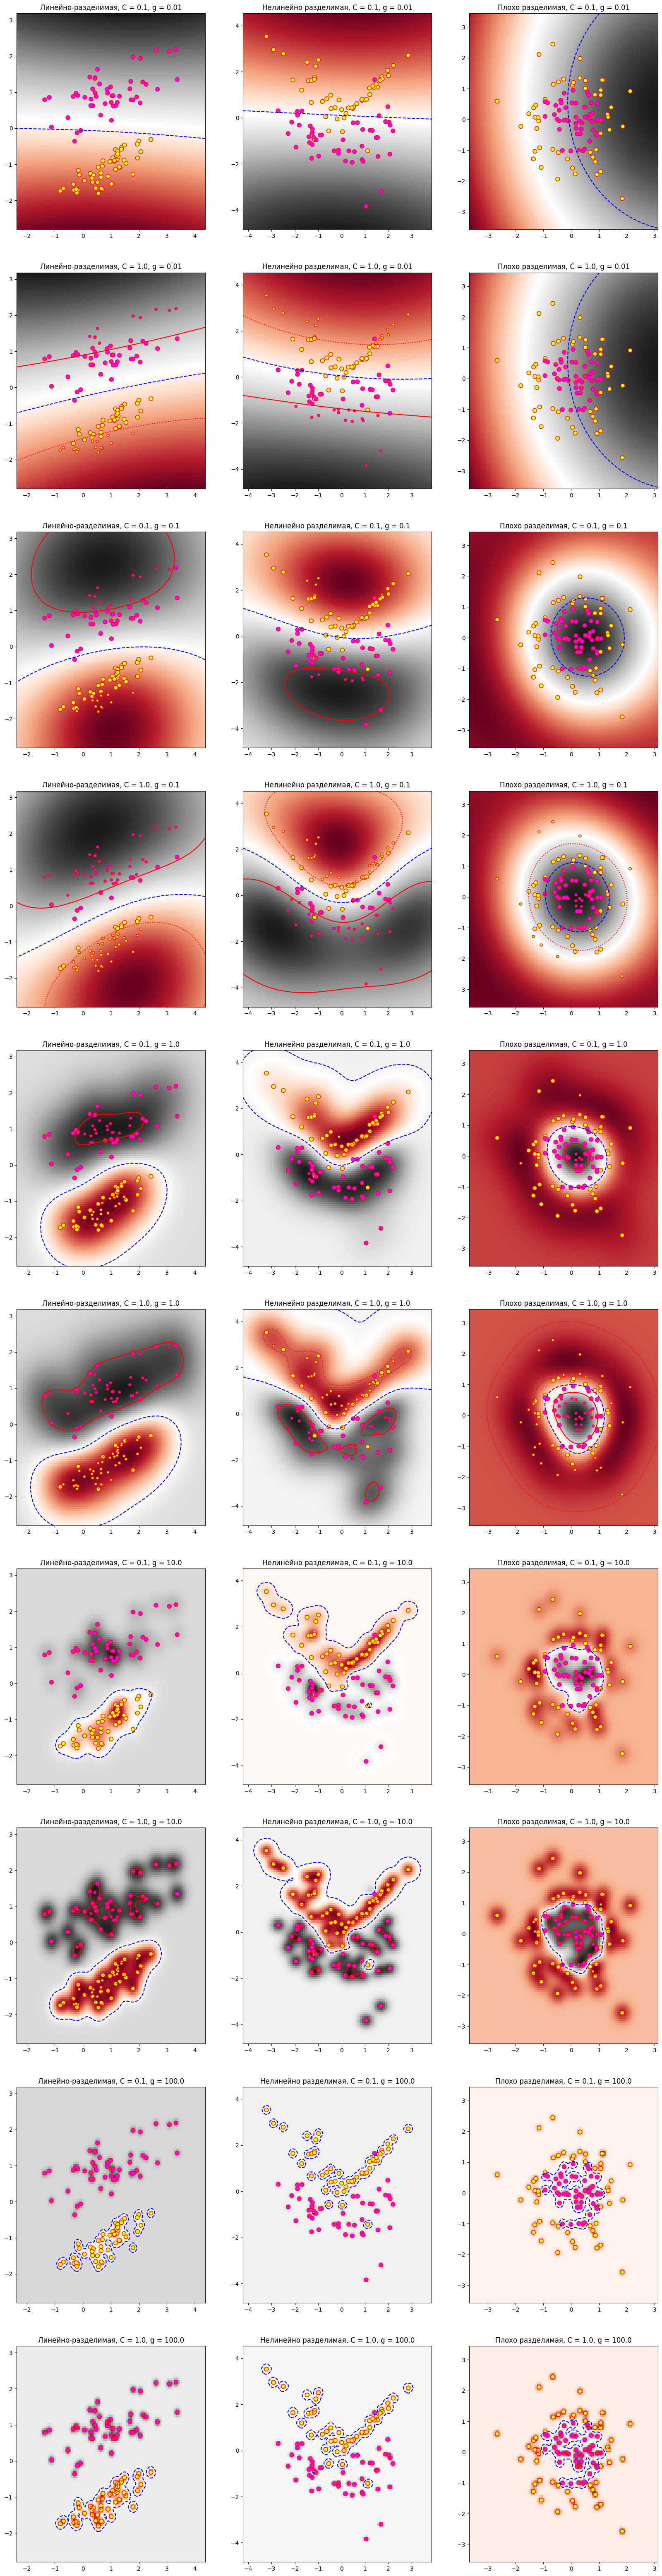

In [27]:
gammas = 10. ** np.arange(-2,3)
cvals, gvals = np.meshgrid(C, gammas)
gg = gvals.flatten()
cc = cvals.flatten()
fig, ax = plt.subplots(len(gg), 3, figsize=(20,80))
for i in range(3):
    for j in range(len(gg)):
        visualize_DualSVM(X[i], y[i], i, j, cc[j], 'RBF', gamma = gg[j])
        ax[j][i].set_title(titles[i] + ', C = ' + str(cc[j]) + ', g = ' + str(gg[j]))